# Quantum Imaginary Time Evolution

In [2]:
import numpy as np
np.warnings.filterwarnings('ignore')

from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools import parallel_map

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

In [3]:
## Testing
N_states=4
encoding="gray_code"
N_qubits = int(np.ceil(np.log2(N_states)))

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,number_circuit_folds=1)
# circuit.draw(output="mpl",filename="circuit.pdf")
# circuit.draw()


# CNOT extrapolation

In [4]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
evolution_set=[H_qubit.weighted_pauli]
time=1
num_cnot_pairs=0


q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())

num_cnot_pairs=1
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())


                                          ┌──────────┐            »
q1_0: ──────────────■──────────────────■──┤ U2(0,pi) ├────────────»
      ┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├──────────┤┌──────────┐»
q1_1: ┤ U2(0,pi) ├┤ X ├┤ U1(7.8262) ├┤ X ├┤ U2(0,pi) ├┤ U2(0,pi) ├»
      └──────────┘└───┘└────────────┘└───┘└──────────┘└──────────┘»
c1_0: ════════════════════════════════════════════════════════════»
                                                                  »
c1_1: ════════════════════════════════════════════════════════════»
                                                                  »
«                                                          ┌──────────┐»
«q1_0: ─────────────────────────────■───────────────────■──┤ U2(0,pi) ├»
«      ┌─────────────┐┌──────────┐┌─┴─┐┌─────────────┐┌─┴─┐└──────────┘»
«q1_1: ┤ U1(-7.8262) ├┤ U2(0,pi) ├┤ X ├┤ U1(-4.2866) ├┤ X ├────────────»
«      └─────────────┘└──────────┘└───┘└─────────────┘└───┘            »
«c1_0: ════════════════

In [5]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit.h(q)
circuit.measure(q,c)
job=execute(circuit,
            backend=Aer.get_backend("qasm_simulator"),
            shots=100
           )
job.result().get_counts(circuit)
# job.result().to_dict()

{'11': 17, '01': 29, '00': 29, '10': 25}

In [6]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None,
    'number_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)      

energies_sv=qite_experiment(H_qubit,parameters)

parameters['backend']='qasm_simulator'
energies_qasm=qite_experiment(H_qubit,parameters)

parameters['number_cnot_pairs']=1
energies_cnot=qite_experiment(H_qubit,parameters)


100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


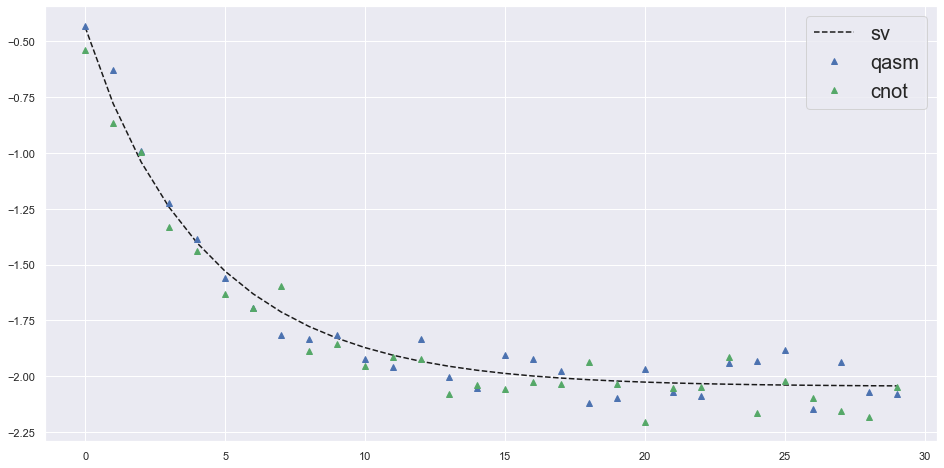

In [7]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm")
plt.plot(time,energies_cnot,'g^',label="cnot")
plt.legend(prop={'size': 20})

# Circuit Folding

In [6]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'number_circuit_folds': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm=qite_experiment(H_qubit,parameters)
parameters['number_circuit_folds']=1
energies_folded=qite_experiment(H_qubit,parameters)



100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


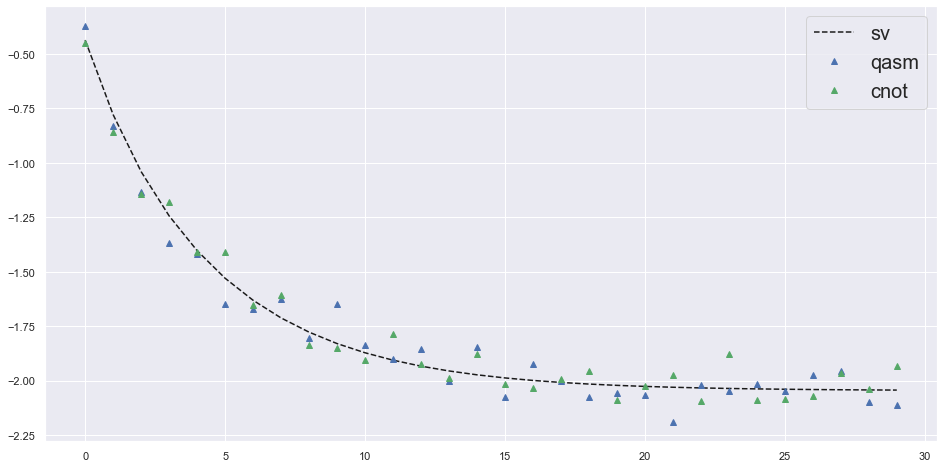

In [7]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm")
plt.plot(time,energies_folded,'g^',label="cnot")
plt.legend(prop={'size': 20})

# QASM with noise

In [8]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 200,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)

parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['merge_step']=None
energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)



  5%|▌         | 10/200 [00:00<00:02, 93.45it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 200/200 [14:52<00:00,  4.46s/it]


[-2.0456709   8.56158173 24.54750806]


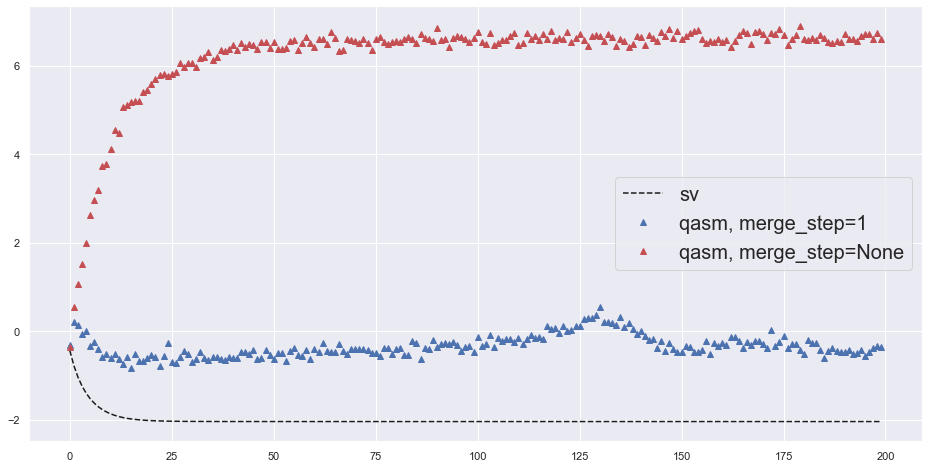

In [9]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(200)]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm, merge_step=1")
plt.plot(time,energies_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [23]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'number_circuit_folds': 0,
    'number_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

num_extrap_step=7
energies_extrap=[]
coefs_extrap=[]
for n in range(0,num_extrap_step+1,1):
    parameters['number_circuit_folds']=n
    parameters['backend']='qasm_simulator'
    energies_qasm_extrap,coefs_qasm_extrap=qite_experiment(H_qubit,parameters)
    energies_extrap.append(energies_qasm_extrap)
    coefs_extrap.append(coefs_qasm_extrap)
# parameters['merge_step']=None
# energies_qasm_no_merge,coefs_qasm_nm=qite_experiment(H_qubit,parameters)

 33%|███▎      | 10/30 [00:00<00:00, 95.26it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


In [29]:
xs=[2*n+1 for n in range(0,num_extrap_step+1,1)]
extrapolated_energies=[]
for energies in np.array(energies_extrap).transpose():
#     print(energies)
#     print(xs)
    coef=np.polyfit(xs,energies,3)
    linear_fit=np.poly1d(coef)
    extrapolated_energies.append(linear_fit(0))    

[-2.0456709   8.56158173 24.54750806]


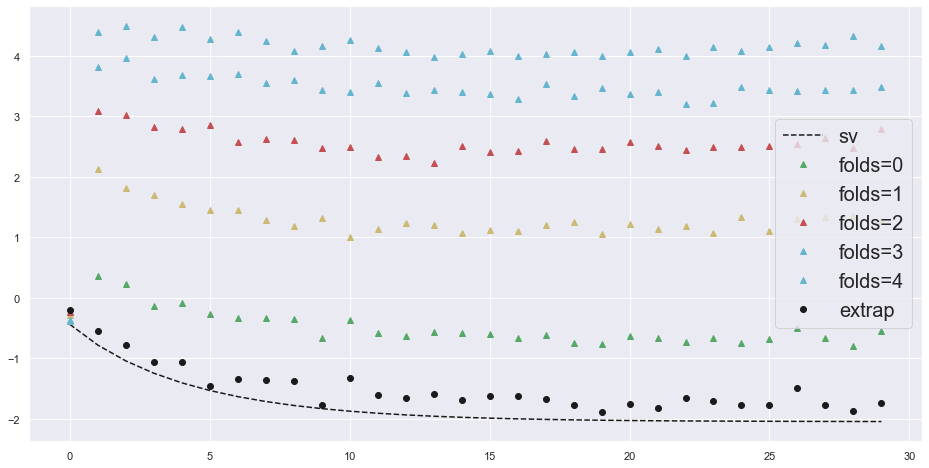

In [30]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
# plt.plot(time,energies_qasm,'b^',label="qasm,merge_step=1")

plt.plot(time,energies_extrap[0],'g^',label="folds=0")
plt.plot(time,energies_extrap[1],'y^',label="folds=1")
plt.plot(time,energies_extrap[2],'r^',label="folds=2")
plt.plot(time,energies_extrap[3],'c^',label="folds=3")
plt.plot(time,energies_extrap[4],'c^',label="folds=4")
plt.plot(time,extrapolated_energies,'ko',label="extrap")
# plt.plot(time,energies_qasm_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [3]:
parameters = {
    'Nmax' : 4,
    'interaction':"N4LOsrg1.5",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'number_circuit_folds': 0,
    'number_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

num_extrap_step=7
energies_extrap=[]
coefs_extrap=[]
for n in range(0,num_extrap_step+1,1):
    parameters['number_circuit_folds']=n
    parameters['backend']='qasm_simulator'
    energies_qasm_extrap,coefs_qasm_extrap=qite_experiment(H_qubit,parameters)
    energies_extrap.append(energies_qasm_extrap)
    coefs_extrap.append(coefs_qasm_extrap)
# parameters['merge_step']=None
# energies_qasm_no_merge,coefs_qasm_nm=qite_experiment(H_qubit,parameters)

  7%|▋         | 2/30 [00:00<00:02, 12.18it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/30 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


100%|██████████| 30/30 [01:56<00:00,  3.90s/it]


In [4]:
xs=[2*n+1 for n in range(0,num_extrap_step+1,1)]
extrapolated_energies=[]
for energies in np.array(energies_extrap).transpose():
#     print(energies)
#     print(xs)
    coef=np.polyfit(xs,energies,3)
    linear_fit=np.poly1d(coef)
    extrapolated_energies.append(linear_fit(0))    

[-1.97785915 11.67564576 17.06953263 37.03491104 51.06144971]


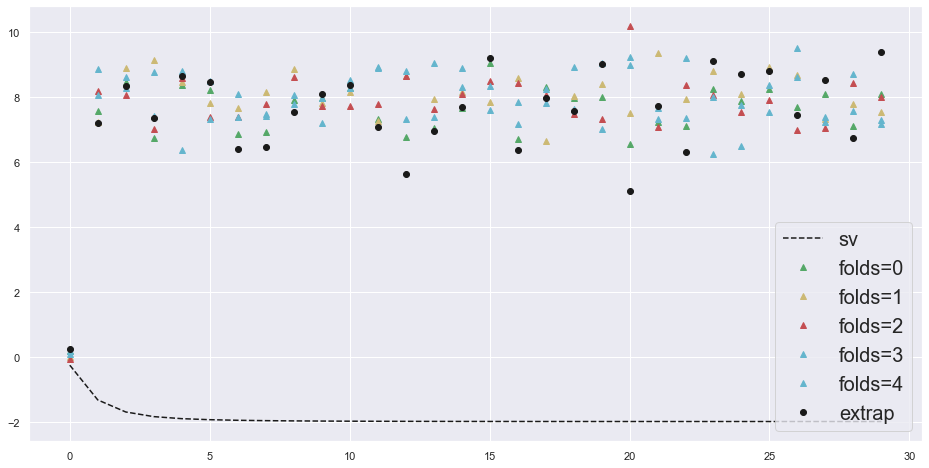

In [5]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
# plt.plot(time,energies_qasm,'b^',label="qasm,merge_step=1")

plt.plot(time,energies_extrap[0],'g^',label="folds=0")
plt.plot(time,energies_extrap[1],'y^',label="folds=1")
plt.plot(time,energies_extrap[2],'r^',label="folds=2")
plt.plot(time,energies_extrap[3],'c^',label="folds=3")
plt.plot(time,energies_extrap[4],'c^',label="folds=4")
plt.plot(time,extrapolated_energies,'ko',label="extrap")
# plt.plot(time,energies_qasm_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [32]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 100,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'N_circuit_folds': 0,
    'N_cnot_pairs': 0
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

num_extrap_step=5
energies_extrap=[]
coefs_extrap=[]
for n in range(num_extrap_step):
    parameters['N_cnot_pairs']=n
    parameters['backend']='qasm_simulator'
    energies_qasm_extrap,coefs_qasm_extrap=qite_experiment(H_qubit,parameters)
    energies_extrap.append(energies_qasm_extrap)
    coefs_extrap.append(coefs_qasm_extrap)

 11%|█         | 11/100 [00:00<00:00, 101.03it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


[-2.0456709   8.56158173 24.54750806]


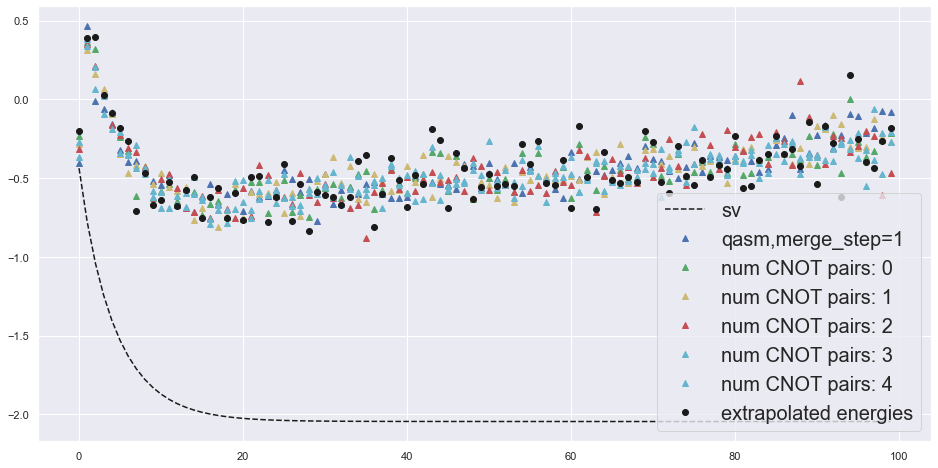

In [33]:
num_extrap_step=2
xs=[2*n+1 for n in range(num_extrap_step)]
extrapolated_energies=[]
for energies in np.array(energies_extrap).transpose():
#     print(energies)
#     print(xs)
    coef=np.polyfit(xs,energies[:num_extrap_step],1)
    linear_fit=np.poly1d(coef)
    extrapolated_energies.append(linear_fit(0))   
    
    
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm,merge_step=1")

plt.plot(time,energies_extrap[0],'g^',label="num CNOT pairs: 0")
plt.plot(time,energies_extrap[1],'y^',label="num CNOT pairs: 1")
plt.plot(time,energies_extrap[2],'r^',label="num CNOT pairs: 2")
plt.plot(time,energies_extrap[3],'c^',label="num CNOT pairs: 3")
plt.plot(time,energies_extrap[4],'c^',label="num CNOT pairs: 4")
plt.plot(time,extrapolated_energies,'ko',label="extrapolated energies")
# plt.plot(time,energies_qasm_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [94]:
num_extrap_step=5
xs=[2*n+1 for n in range(num_extrap_step)]
energies=np.array(energies_extrap).transpose()[0]
coef=np.polyfit(xs,energies[:num_extrap_step],3,full=True)
ee, res, rank, sv, rc=coef
# print(coef)
print(ee)
print(1-res)
#residuals, rank, singular_values, rcond

[-0.00227965  0.03303066 -0.1428164  -0.1731905 ]
[0.99957511]


In [6]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'jordan_wigner',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 50,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = JordanWignerHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)
parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['merge_step']=None
energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)


 10%|█         | 5/50 [00:00<00:00, 48.54it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_3qubits.pkl


100%|██████████| 50/50 [20:34<00:00, 24.69s/it]


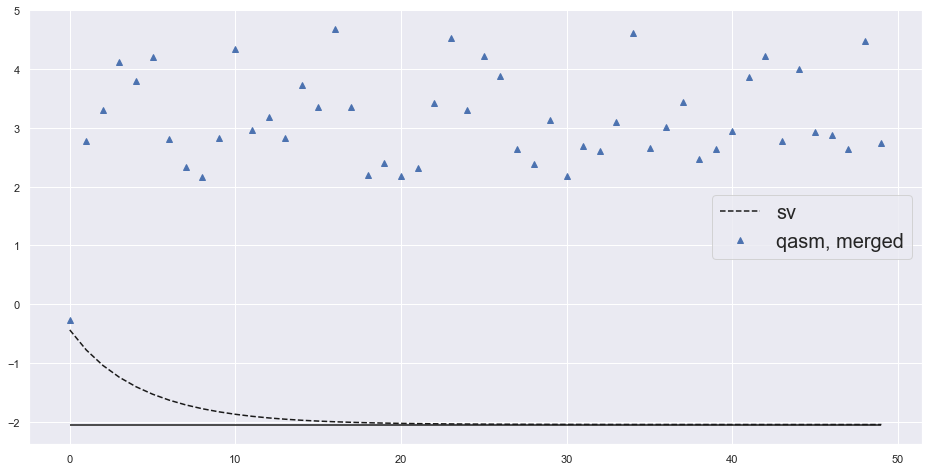

In [7]:
eigs,_=eigh(H)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm, merged")
# plt.plot(time,energies_no_merge,'r^',label="qasm")
plt.hlines(eigs[0],0,parameters['N_time_steps']-1)
plt.legend(prop={'size': 20})

In [80]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'uniform',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 200,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)

parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['merge_step']=None
energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)



  5%|▌         | 10/200 [00:00<00:02, 92.79it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 200/200 [50:15<00:00, 15.08s/it]   


[-2.0456709   8.56158173 24.54750806]


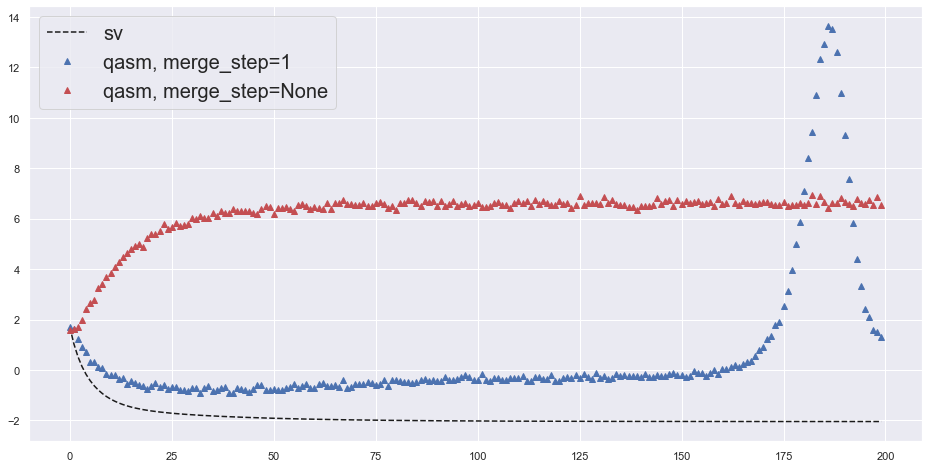

In [81]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(200)]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="qasm, merge_step=1")
plt.plot(time,energies_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

# Testing Extrapolation between time steps

In [4]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 50,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'number_circuit_folds': 0,
    'number_cnot_pairs': 0,
    'zero_noise_extrapolation':False,
    'degree_extrapolation_polynomial':1
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)

parameters['backend']='qasm_simulator'
energies_qasm,coefs_qasm=qite_experiment(H_qubit,parameters)

parameters['number_circuit_folds']=4
parameters['zero_noise_extrapolation']=True
extrap_energies=[]
for n in range(1,parameters['number_circuit_folds']+1,1):
    parameters['degree_extrapolation_polynomial']=n
    energies_qasm_extrap,coefs_qasm_extrap=qite_experiment(H_qubit,parameters)
    extrap_energies.append(energies_qasm_extrap)

    # parameters['merge_step']=None
# energies_no_merge,coefs_no_merge=qite_experiment(H_qubit,parameters)



 18%|█▊        | 9/50 [00:00<00:00, 82.92it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Extrapolating with circuit_folding
Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Extrapolating with circuit_folding
Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Extrapolating with circuit_folding
Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

Extrapolating with circuit_folding
Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


100%|██████████| 50/50 [02:15<00:00,  2.70s/it]


[-2.0456709   8.56158173 24.54750806]


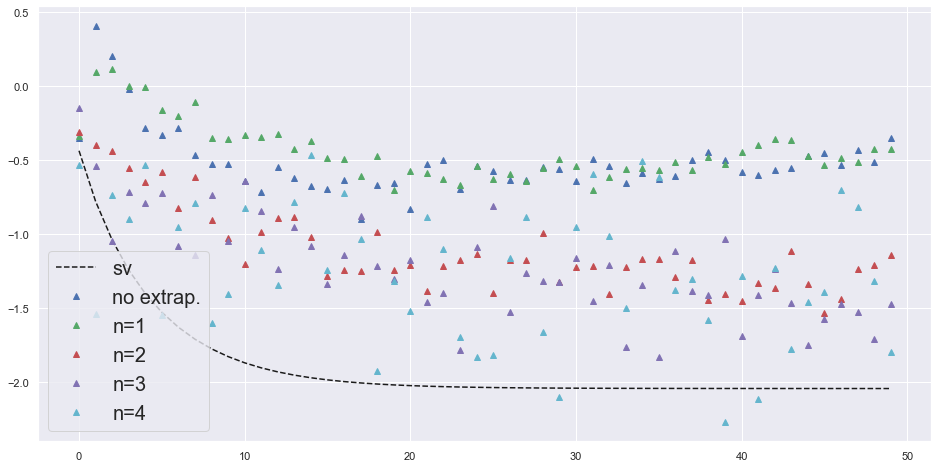

In [7]:
eigs,_=eigh(H)
print(eigs)
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,energies_sv,'k--',label="sv")
plt.plot(time,energies_qasm,'b^',label="no extrap.")
plt.plot(time,extrap_energies[0],'g^',label="n=1")
plt.plot(time,extrap_energies[1],'r^',label="n=2")
plt.plot(time,extrap_energies[2],'m^',label="n=3")
plt.plot(time,extrap_energies[3],'c^',label="n=4")
# plt.plot(time,energies_no_merge,'r^',label="qasm, merge_step=None")
plt.legend(prop={'size': 20})

In [2]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 5,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'device_name':'ibmq_vigo',
    'mitigate_meas_error' : True,
    'qlanczos':True,
    'number_circuit_folds': 0,
    'number_cnot_pairs': 0,
    'zero_noise_extrapolation':False,
    'degree_extrapolation_polynomial':1
    }

parameters=set_qite_parameters(parameters,verbose=False)
H = hamiltonian_matrix(parameters['Nmax'],J=1,interaction=parameters["interaction"])
H_qubit = GrayCodeHamiltonian(H)      

energies_sv,coefs_sv=qite_experiment(H_qubit,parameters)

# parameters['number_circuit_folds']=4
# parameters['zero_noise_extrapolation']=True
# extrap_energies=[]
# for n in range(1,parameters['number_circuit_folds']+1,1):
#     parameters['degree_extrapolation_polynomial']=n
#     energies_sv_extrap,coefs_sv_extrap=qite_experiment(H_qubit,parameters)
#     extrap_energies.append(energies_sv_extrap)
    


  0%|          | 0/5 [00:00<?, ?it/s]

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 32)